## Data loading

In [66]:
import pandas as pd
import seaborn as sns
sns.set_theme()
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import json
from scipy import stats

import sys
sys.path.append('..')
from helpers import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# First glimpse of all the available movies in the dataset

column_movies = ["film_id", "movie_id", "title", "release_date", "gross_revenue", "duration_min", "language", "country", "categories"]

movies_df = pd.read_csv('../Data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, names=column_movies)
movies_df.head()

,film_id,movie_id,title,release_date,gross_revenue,duration_min,language,country,categories
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Dataframe of all the characters in the movies

column_characters = ["film_id", "movie_id", "release_date", "character", "born_date", "gender", "height", "ethnicity", "actor_name", "actor_age_at_movie_release", "actor_map_ID","character_ID","actor_ID"]

character_df = pd.read_csv('../Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names = column_characters)
character_df.head()

,film_id,movie_id,release_date,character,born_date,gender,height,ethnicity,actor_name,actor_age_at_movie_release,actor_map_ID,character_ID,actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
# List of different actors 
actors = character_df['actor_name'].unique()

# Number of actors per movie  
films = character_df.groupby('movie_id').actor_name.count()

# Number of characters per movie 
char = character_df.groupby('movie_id').character.count()

We may look at the frequency of different actors (nb of movies/year), look at the histogram of number of times each actor played (distrib), look at when the age started (distrib), ...

## 1. Frequency of presence in movies per year 

### 1.1) Simple frequency of presence

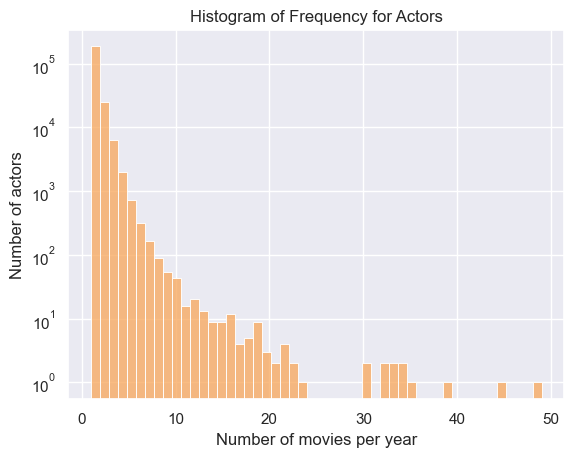

In [6]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

frequency_df = character_df.groupby(['actor_name', character_df['release_date'].dt.year]).size().reset_index(name='movie_count')

frequency_df = frequency_df.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
frequency_df = frequency_df.drop_duplicates(subset=['actor_name', 'release_date'])

count_char_df = pd.merge(character_df, movies_df[['movie_id', 'country']], on='movie_id', how='left')
count_char_df["country"] = (count_char_df["country"].apply(json.loads).apply(format_of_country_change))
count_char_df['region'] = count_char_df['country'].apply(get_region)

frequency_df = frequency_df.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
frequency_df = frequency_df.drop_duplicates(subset=['actor_name', 'release_date'])


sns.histplot(frequency_df['movie_count'], bins= 50, log = True, color = '#f8a65a')
plt.ylabel("Number of actors")
plt.xlabel("Number of movies per year")
plt.title('Histogram of Frequency for Actors')
plt.show()

Possible limitations of the graph : outliers (we may look at who they are) and does a huge frquency over one year is better than a constant lower frequency ?  

In [7]:
frequency_max = frequency_df.sort_values(by='movie_count', ascending=False)
top5_frequency = frequency_max.head(5)
print(top5_frequency)

              actor_name  release_date  movie_count gender         region
2782038  Roscoe Arbuckle        1914.0           49      M  North America
2362269     Oliver Hardy        1916.0           45      M  North America
1129307     Harold Lloyd        1919.0           39      M  North America
2781880  Roscoe Arbuckle        1913.0           35      M  North America
481818   Charlie Chaplin        1914.0           34      M  North America


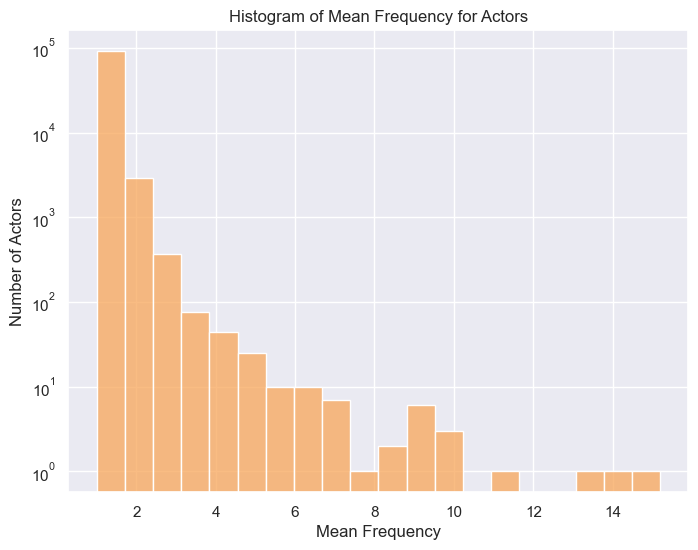

In [8]:
mean_frequency = frequency_df.groupby('actor_name')['movie_count'].mean().reset_index(name='mean_frequency')
mean_frequency = mean_frequency.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
mean_frequency = mean_frequency.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')

mean_frequency = mean_frequency.drop_duplicates(subset=['actor_name'])

plt.figure(figsize=(8, 6))
sns.histplot(mean_frequency['mean_frequency'], bins=20,log = True, kde=False, color = '#f8a65a')
plt.xlabel('Mean Frequency')
plt.ylabel('Number of Actors')
plt.title('Histogram of Mean Frequency for Actors')
plt.show()

In [9]:
mean_frequency.head()

,actor_name,mean_frequency,gender,region
0,Cesarine Prinz\t,1.0,F,Other
4,Daniel Newman,1.0,M,North America
5,'Big Bill' Giddinger,1.0,M,North America
6,'Big' Lee,1.0,M,North America
7,'Chicken' Holleman,1.0,NaN,North America


In [10]:
top5_actors_mf = mean_frequency.nlargest(5, 'mean_frequency')
print(top5_actors_mf)

               actor_name  mean_frequency gender         region
1318450  Charlotte Burton            15.2      F  North America
4985633     Louise Lester            14.0      F  North America
3307334        Jack Davis            13.5    NaN  North America
9607198       Vivian Rich            11.2      F  North America
1185136    Caroline Cooke            10.0      F  North America


When we search for all these actors, we can see that they are all from the beginning of the movie industry (1910s, early 1920s) when the movies were quite short and silent, so the artistic approach was way more simplified as today. In fact, Roscoe Arbuckle worked as the same time as an actor, a screenwriter and a producer. 

By highlighting that, we could assess that taking into account the period at which the movies were produced is critical. 

So, we tried to filter by period : 

In [11]:
average_movie_count_per_year = frequency_df.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_per_year.columns = ['release_date', 'average_movies', 'std_dev']
average_movie_count_per_year.head(13)

,release_date,average_movies,std_dev
0,1894.0,1.000,NaN
1,1895.0,1.000,NaN
2,1896.0,1.000,0.000000
3,1897.0,1.000,NaN
4,1900.0,1.000,0.000000
5,1901.0,1.000,NaN
6,1902.0,1.000,0.000000
7,1903.0,1.000,0.000000
8,1904.0,1.000,NaN
9,1905.0,1.000,0.000000


We can filter all the years before 1908 which seems not very insightful, and then plot the average frequency per year with the standard deviation : 

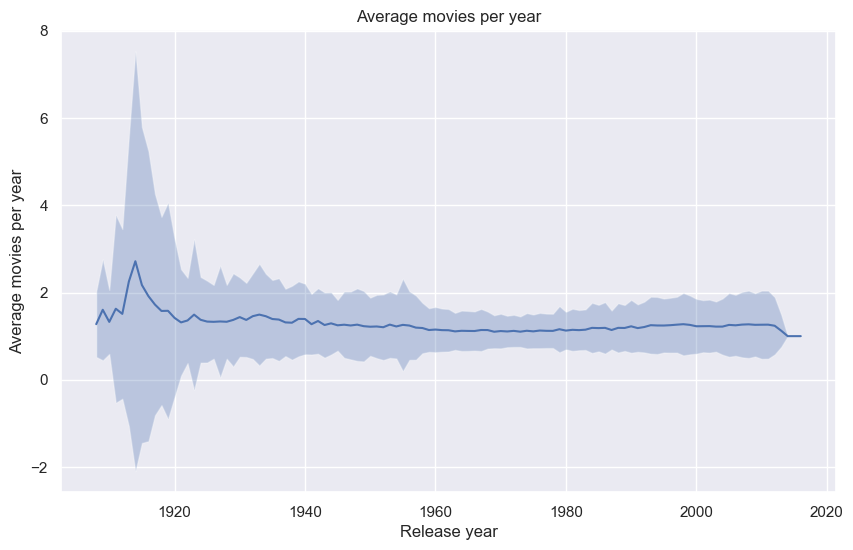

In [12]:
average_movie_count_per_year = average_movie_count_per_year[average_movie_count_per_year['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_per_year, x='release_date', y='average_movies')
plt.fill_between(average_movie_count_per_year['release_date'], 
                 average_movie_count_per_year['average_movies'] - average_movie_count_per_year['std_dev'],
                 average_movie_count_per_year['average_movies'] + average_movie_count_per_year['std_dev'],
                 alpha=0.3)
plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year')
plt.grid(True)
plt.show()

### 1.2) Frequency of presence by gender

We could also focus on gender through time :

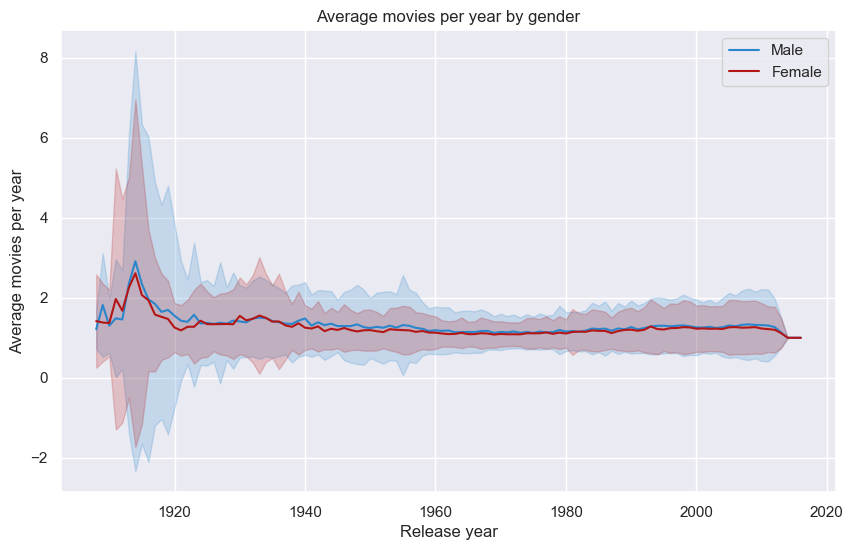

In [73]:
male_data = frequency_df[frequency_df['gender'] == 'M']
female_data = frequency_df[frequency_df['gender'] == 'F']

average_movie_count_male = male_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_male = average_movie_count_male[average_movie_count_male['release_date'] >= 1908]

average_movie_count_female = female_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_female = average_movie_count_female[average_movie_count_female['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_male, x='release_date', y='mean', label='Male', color = '#2986cc')
plt.fill_between(average_movie_count_male['release_date'], 
                 average_movie_count_male['mean'] - average_movie_count_male['std'],
                 average_movie_count_male['mean'] + average_movie_count_male['std'],
                 alpha=0.2, color = '#2986cc')

sns.lineplot(data=average_movie_count_female, x='release_date', y='mean', label='Female', color='#b41515')
plt.fill_between(average_movie_count_female['release_date'], 
                 average_movie_count_female['mean'] - average_movie_count_female['std'],
                 average_movie_count_female['mean'] + average_movie_count_female['std'],
                 alpha=0.2, color='#b41515')

plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year by gender')
plt.legend()
plt.grid(True)
plt.show()

### 1.3) Frequency of presence by region

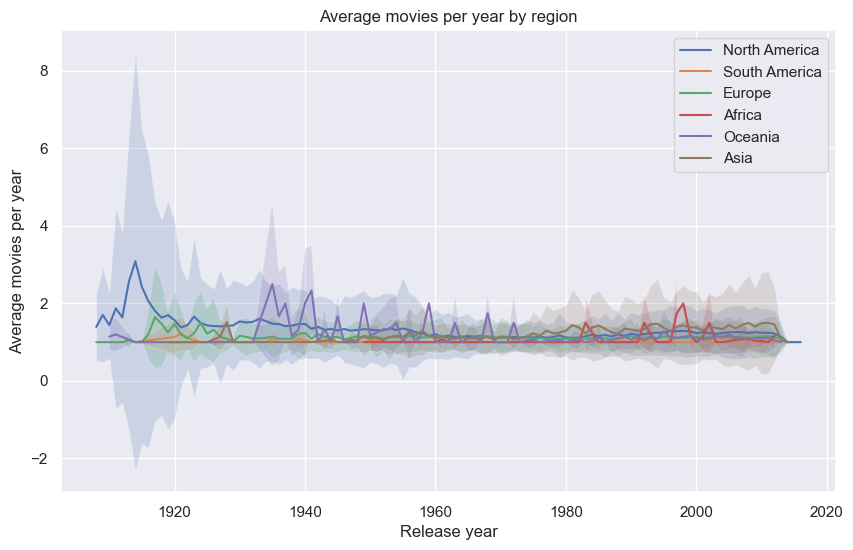

In [14]:
NA_data = frequency_df[frequency_df['region'] == 'North America']
SA_data = frequency_df[frequency_df['region'] == 'South America']
EU_data = frequency_df[frequency_df['region'] == 'Europe']
AF_data = frequency_df[frequency_df['region'] == 'Africa']
OC_data = frequency_df[frequency_df['region'] == 'Oceania']
AS_data = frequency_df[frequency_df['region'] == 'Asia']

average_movie_count_NA = NA_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_NA = average_movie_count_NA[average_movie_count_NA['release_date'] >= 1908]

average_movie_count_SA = SA_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_SA = average_movie_count_SA[average_movie_count_SA['release_date'] >= 1908]

average_movie_count_EU = EU_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_EU = average_movie_count_EU[average_movie_count_EU['release_date'] >= 1908]

average_movie_count_AF = AF_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_AF = average_movie_count_AF[average_movie_count_AF['release_date'] >= 1908]

average_movie_count_OC = OC_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_OC = average_movie_count_OC[average_movie_count_OC['release_date'] >= 1908]

average_movie_count_AS = AS_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_AS = average_movie_count_AS[average_movie_count_AS['release_date'] >= 1908]


plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_NA, x='release_date', y='mean', label='North America')
plt.fill_between(average_movie_count_NA['release_date'], 
                 average_movie_count_NA['mean'] - average_movie_count_NA['std'],
                 average_movie_count_NA['mean'] + average_movie_count_NA['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_SA, x='release_date', y='mean', label='South America')
plt.fill_between(average_movie_count_SA['release_date'], 
                 average_movie_count_SA['mean'] - average_movie_count_SA['std'],
                 average_movie_count_SA['mean'] + average_movie_count_SA['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_EU, x='release_date', y='mean', label='Europe')
plt.fill_between(average_movie_count_EU['release_date'], 
                 average_movie_count_EU['mean'] - average_movie_count_EU['std'],
                 average_movie_count_EU['mean'] + average_movie_count_EU['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_AF, x='release_date', y='mean', label='Africa')
plt.fill_between(average_movie_count_AF['release_date'], 
                 average_movie_count_AF['mean'] - average_movie_count_AF['std'],
                 average_movie_count_AF['mean'] + average_movie_count_AF['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_OC, x='release_date', y='mean', label='Oceania')
plt.fill_between(average_movie_count_OC['release_date'], 
                 average_movie_count_OC['mean'] - average_movie_count_OC['std'],
                 average_movie_count_OC['mean'] + average_movie_count_OC['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_AS, x='release_date', y='mean', label='Asia')
plt.fill_between(average_movie_count_AS['release_date'], 
                 average_movie_count_AS['mean'] - average_movie_count_AS['std'],
                 average_movie_count_AS['mean'] + average_movie_count_AS['std'],
                 alpha=0.2)

plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year by region')
plt.legend()
plt.grid(True)
plt.show()

## 2. Career span of actors

### 2.2) Career span of actors by gender

In [15]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

actor_span = character_df.groupby('actor_name')['release_date'].agg(['min', 'max']).reset_index()
actor_span['career_span'] = (actor_span['max'] - actor_span['min']).dt.days / 365

# Avoid anomalies due to missing values (NaT)
span_thresh = 50 
actor_span = actor_span[(actor_span['career_span'] != 0) & (actor_span['career_span'] < span_thresh)]
actor_career_span = actor_span.merge(character_df[['actor_name', 'actor_age_at_movie_release', 'gender']], on='actor_name', how='inner')
actor_career_span['mid_career_age'] = actor_career_span['actor_age_at_movie_release'] + (actor_career_span['career_span'] / 2)

actor_career_span = actor_career_span.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
actor_career_span = actor_career_span.drop_duplicates(subset=['actor_name', 'career_span', 'gender'])
actor_career_span.head()


,actor_name,min,max,career_span,actor_age_at_movie_release,gender,mid_career_age,region
0,Cesarine Prinz\t,1922-08-04,1926-10-29,4.238356,NaN,F,NaN,Other
4,50 Cent,2003-04-15,2011-09-20,8.438356,33.0,M,37.219178,North America
533,A Martinez,1996-09-16,2011-01-29,14.378082,47.0,M,54.189041,North America
654,A. E. Matthews,1941-04-19,1952-06-10,11.150685,NaN,M,NaN,Europe
735,A. J. Benza,2000-03-30,2006-12-20,6.728767,39.0,M,42.364384,North America


Mean career span for male actors: 13.08 years (+/-  11.21) 
Mean career span for female actors: 11.38 years (+/- 10.74) 


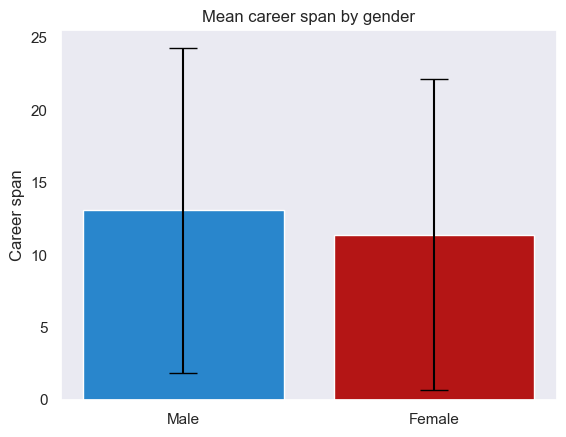

In [16]:
male_actors = actor_career_span[actor_career_span['gender'] == 'M']
female_actors = actor_career_span[actor_career_span['gender'] == 'F']

mean_career_span_male = male_actors['career_span'].mean()
std_career_span_male = male_actors['career_span'].std()
mean_career_span_female = female_actors['career_span'].mean()
std_career_span_female = female_actors['career_span'].std()

print(f"Mean career span for male actors: {mean_career_span_male:.2f} years (+/-  {std_career_span_male:.2f}) ")
print(f"Mean career span for female actors: {mean_career_span_female:.2f} years (+/- {std_career_span_female:.2f}) ")

labels = ['Male', 'Female']
bar_colors = ['#2986cc', '#b41515']
x_pos = range(len(labels))
plt.bar(x_pos, [mean_career_span_male, mean_career_span_female],
        yerr=[std_career_span_male, std_career_span_female],
        align='center', ecolor='black', capsize=10, color=bar_colors)
plt.xticks(x_pos, labels)
plt.ylabel('Career span')
plt.title('Mean career span by gender')
plt.grid()
plt.show()

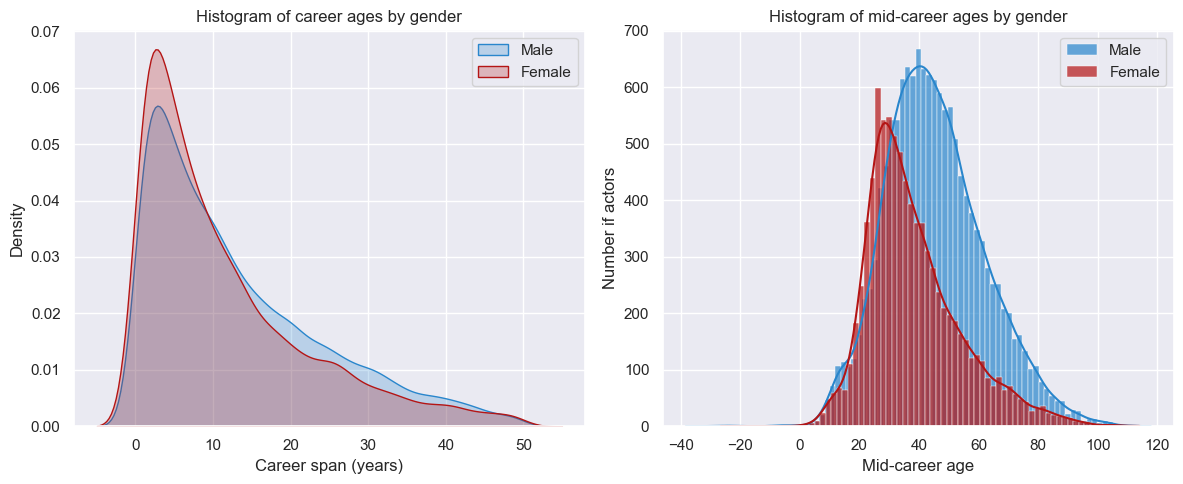

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(male_actors['career_span'], label='Male', shade=True, color='#2986cc', ax=axs[0])
sns.kdeplot(female_actors['career_span'], label='Female', shade=True, color='#b41515', ax=axs[0])
axs[0].set_xlabel('Career span (years)')
axs[0].set_ylabel('Density')
axs[0].set_title('Histogram of career ages by gender')
axs[0].legend()
axs[0].grid(True)

male_mid_career = actor_career_span[actor_career_span['gender'] == 'M']['mid_career_age']
female_mid_career = actor_career_span[actor_career_span['gender'] == 'F']['mid_career_age']

sns.histplot(male_mid_career, kde=True, label='Male', color='#2986cc', alpha=0.7, ax=axs[1])
sns.histplot(female_mid_career, kde=True, label='Female', color='#b41515', alpha=0.7, ax=axs[1])

axs[1].set_xlabel('Mid-career age')
axs[1].set_ylabel('Number if actors')
axs[1].set_title('Histogram of mid-career ages by gender')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

This is a relatively high variance, so we can not assess anything about the career span of male or female yet. Let's try to do a t-test : 

In [18]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(male_actors['career_span'], female_actors['career_span'])

print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.4f}")

t-statistic: 13.15, p-value: 0.0000


We can assess that there is strong evidence about the difference between male and female actors. 

### 2.2) Career span of actors by region

In [19]:
NA_actors = actor_career_span[actor_career_span['region'] == 'North America']
SA_actors = actor_career_span[actor_career_span['region'] == 'South America']
EU_actors = actor_career_span[actor_career_span['region'] == 'Europe']
AS_actors = actor_career_span[actor_career_span['region'] == 'Asia']
AF_actors = actor_career_span[actor_career_span['region'] == 'Africa']
OC_actors = actor_career_span[actor_career_span['region'] == 'Oceania']

mean_career_span_NA = NA_actors['career_span'].mean()
std_career_span_NA = NA_actors['career_span'].std()
mean_career_span_SA = SA_actors['career_span'].mean()
std_career_span_SA = SA_actors['career_span'].std()
mean_career_span_EU = EU_actors['career_span'].mean()
std_career_span_EU = EU_actors['career_span'].std()
mean_career_span_AS = AS_actors['career_span'].mean()
std_career_span_AS = AS_actors['career_span'].std()
mean_career_span_AF = AF_actors['career_span'].mean()
std_career_span_AF = AF_actors['career_span'].std()
mean_career_span_OC = OC_actors['career_span'].mean()
std_career_span_OC = OC_actors['career_span'].std()

print(f"Mean career span for North America actors: {mean_career_span_NA:.2f} years (+/-  {std_career_span_NA:.2f}) ")
print(f"Mean career span for South America actors: {mean_career_span_SA:.2f} years (+/- {std_career_span_SA:.2f}) ")
print(f"Mean career span for Europe actors: {mean_career_span_EU:.2f} years (+/-  {std_career_span_EU:.2f}) ")
print(f"Mean career span for Asia actors: {mean_career_span_AS:.2f} years (+/- {std_career_span_AS:.2f}) ")
print(f"Mean career span for Africa actors: {mean_career_span_AF:.2f} years (+/-  {std_career_span_AF:.2f}) ")
print(f"Mean career span for Oceania actors: {mean_career_span_OC:.2f} years (+/- {std_career_span_OC:.2f}) ")

Mean career span for North America actors: 12.47 years (+/-  10.98) 
Mean career span for South America actors: 10.59 years (+/- 10.28) 
Mean career span for Europe actors: 12.62 years (+/-  11.56) 
Mean career span for Asia actors: 11.23 years (+/- 10.66) 
Mean career span for Africa actors: 8.40 years (+/-  8.84) 
Mean career span for Oceania actors: 11.45 years (+/- 10.44) 


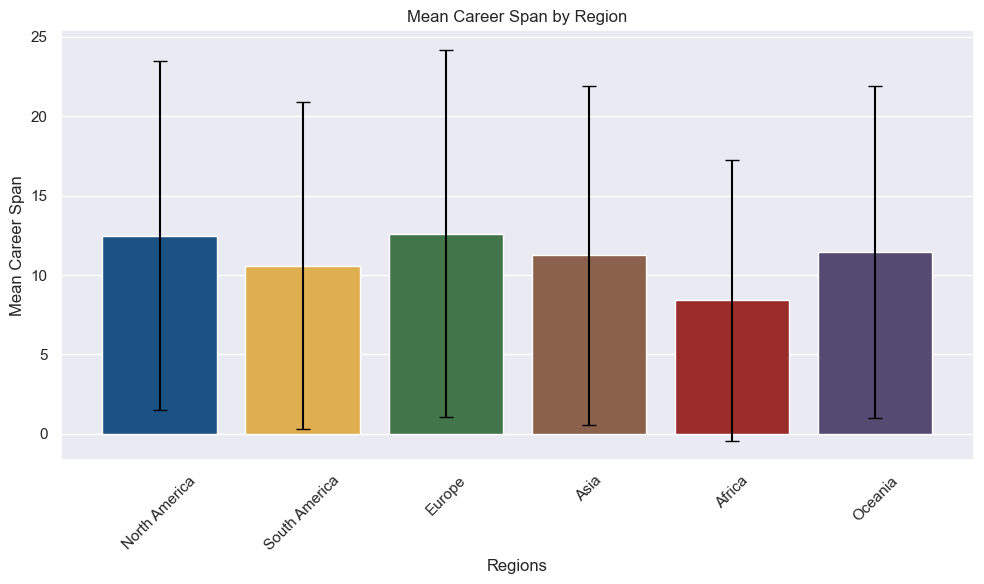

In [20]:
regions = ['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']
mean_career_spans = [mean_career_span_NA, mean_career_span_SA, mean_career_span_EU, mean_career_span_AS, mean_career_span_AF, mean_career_span_OC]
std_career_spans = [std_career_span_NA, std_career_span_SA, std_career_span_EU, std_career_span_AS, std_career_span_AF, std_career_span_OC]

colors = ['#0b5394', '#f7b538', '#3a7d44', '#955e42', '#ac1a1a', '#524379']

plt.figure(figsize=(10, 6))

sns.barplot(x=regions, y=mean_career_spans, palette=colors, errorbar='sd')
plt.errorbar(x=regions, y=mean_career_spans, yerr=std_career_spans, fmt='none', ecolor='black', capsize=5)

plt.xlabel('Regions')
plt.ylabel('Mean Career Span')
plt.title('Mean Career Span by Region')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

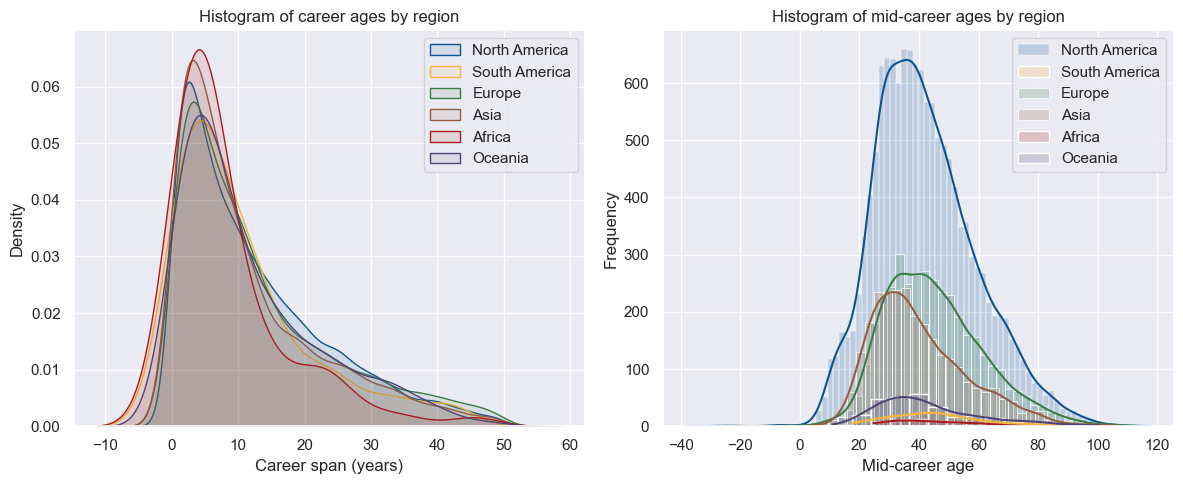

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(NA_actors['career_span'], label='North America', shade=True, color='#0b5394', alpha=0.1, ax=axs[0])
sns.kdeplot(SA_actors['career_span'], label='South America', shade=True, color='#f7b538', alpha=0.1, ax=axs[0])
sns.kdeplot(EU_actors['career_span'], label='Europe', shade=True, color='#3a7d44', alpha=0.1, ax=axs[0])
sns.kdeplot(AS_actors['career_span'], label='Asia', shade=True, color='#955e42', alpha=0.1, ax=axs[0])
sns.kdeplot(AF_actors['career_span'], label='Africa', shade=True, color='#ac1a1a', alpha=0.1, ax=axs[0])
sns.kdeplot(OC_actors['career_span'], label='Oceania', shade=True, color='#524379', alpha=0.1, ax=axs[0])

axs[0].set_xlabel('Career span (years)')
axs[0].set_ylabel('Density')
axs[0].set_title('Histogram of career ages by region')
axs[0].legend()
axs[0].grid(True)

NA_mid_career = actor_career_span[actor_career_span['region'] == 'North America']['mid_career_age']
SA_mid_career = actor_career_span[actor_career_span['region'] == 'South America']['mid_career_age']
EU_mid_career = actor_career_span[actor_career_span['region'] == 'Europe']['mid_career_age']
AS_mid_career = actor_career_span[actor_career_span['region'] == 'Asia']['mid_career_age']
AF_mid_career = actor_career_span[actor_career_span['region'] == 'Africa']['mid_career_age']
OC_mid_career = actor_career_span[actor_career_span['region'] == 'Oceania']['mid_career_age']

sns.histplot(NA_mid_career, kde=True, label='North America', color='#0b5394', alpha=0.2, ax=axs[1])
sns.histplot(SA_mid_career, kde=True, label='South America', color='#f7b538', alpha=0.2, ax=axs[1])
sns.histplot(EU_mid_career, kde=True, label='Europe', color='#3a7d44', alpha=0.2, ax=axs[1])
sns.histplot(AS_mid_career, kde=True, label='Asia', color='#955e42', alpha=0.2, ax=axs[1])
sns.histplot(AF_mid_career, kde=True, label='Africa', color='#ac1a1a', alpha=0.2, ax=axs[1])
sns.histplot(OC_mid_career, kde=True, label='Oceania', color='#524379', alpha=0.2, ax=axs[1])

axs[1].set_xlabel('Mid-career age')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of mid-career ages by region')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## 3. Number of movies per actor

### 3.1) General analysis

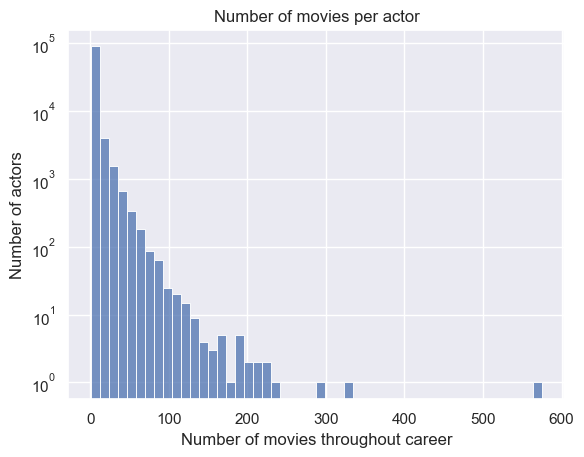

In [22]:
actor_nb_movie = character_df.groupby(['actor_name', 'gender', 'movie_id']).size().reset_index(name='appearance_count')
actor_nb_movie = actor_nb_movie.groupby(['actor_name', 'gender']).size().reset_index(name='total_movie_count')
actor_nb_movie = actor_nb_movie.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
actor_nb_movie = actor_nb_movie.drop_duplicates(subset=['actor_name'])


sns.histplot(actor_nb_movie, x='total_movie_count', bins=50, log=True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor")
plt.show()

In [23]:
actor_nb_movie.head()

,actor_name,gender,total_movie_count,region
0,Cesarine Prinz\t,F,2,Other
2,Daniel Newman,M,1,North America
3,'Big Bill' Giddinger,M,1,North America
4,'Big' Lee,M,1,North America
5,'Crazy George' Henderson,M,1,North America


In [24]:
sorted_actors = actor_nb_movie.sort_values(by='total_movie_count', ascending=False) 
top_5_actors_corrected = sorted_actors.head(5)
print(top_5_actors_corrected)

                actor_name gender  total_movie_count         region
254905           Mel Blanc      M                575  North America
267366  Mithun Chakraborty      M                328          Other
284085        Oliver Hardy      M                299  North America
268496            Mohanlal      M                234           Asia
237509           Mammootty      M                225          Other


The top 5 is mainly composed of mens, let's try to compare with women. In fact, we may have to consider productions locally and by period too, because the leaderboard is exclusively from America in the early ages of cinema and from India nowadays for example.

### 3.2) Number of movies by gender

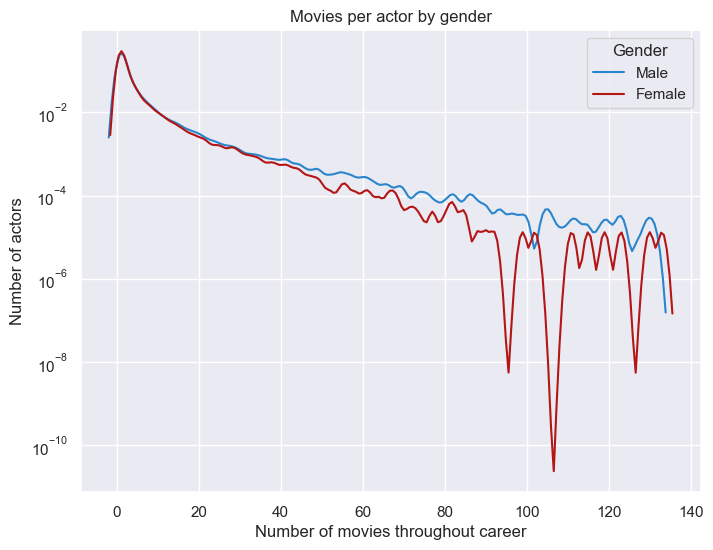

In [25]:
male_data = actor_nb_movie[actor_nb_movie['gender'] == 'M']
female_data = actor_nb_movie[actor_nb_movie['gender'] == 'F']

# The max number of movies for women are 133 so we filter values above to compare
male_filtered = male_data[male_data['total_movie_count'] <= 133]
female_filtered = female_data[female_data['total_movie_count'] <= 133]

# Plotting separate histograms for men and women with filtered data
plt.figure(figsize=(8, 6))
sns.kdeplot(data=male_filtered['total_movie_count'], label='Male', color = '#2986cc')
sns.kdeplot(data=female_filtered['total_movie_count'], label='Female', color = '#b41515')

plt.yscale('log')  # Setting logarithmic scale for y-axis

plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Movies per actor by gender")
plt.legend(title='Gender')
plt.show()

### 3.3) Number of movies per region

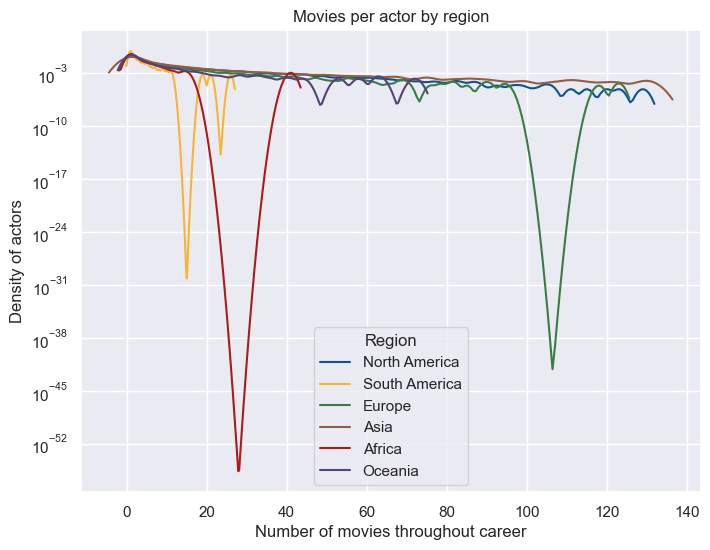

In [28]:
NA_films = actor_nb_movie[actor_nb_movie['region'] == 'North America']
SA_films = actor_nb_movie[actor_nb_movie['region'] == 'South America']
EU_films = actor_nb_movie[actor_nb_movie['region'] == 'Europe']
AS_films = actor_nb_movie[actor_nb_movie['region'] == 'Asia']
AF_films = actor_nb_movie[actor_nb_movie['region'] == 'Africa']
OC_films = actor_nb_movie[actor_nb_movie['region'] == 'Oceania']

NA_films_filtered = NA_films[NA_films['total_movie_count'] <= 133]
SA_films_filtered = SA_films[SA_films['total_movie_count'] <= 133]
EU_films_filtered = EU_films[EU_films['total_movie_count'] <= 133]
AS_films_filtered = AS_films[AS_films['total_movie_count'] <= 133]
AF_films_filtered = AF_films[AF_films['total_movie_count'] <= 133]
OC_films_filtered = OC_films[OC_films['total_movie_count'] <= 133]

plt.figure(figsize=(8, 6))
sns.kdeplot(data=NA_films_filtered['total_movie_count'], label='North America', color = '#0b5394')
sns.kdeplot(data=SA_films_filtered['total_movie_count'], label='South America', color = '#f7b538')
sns.kdeplot(data=EU_films_filtered['total_movie_count'], label='Europe', color = '#3a7d44')
sns.kdeplot(data=AS_films_filtered['total_movie_count'], label='Asia', color = '#955e42')
sns.kdeplot(data=AF_films_filtered['total_movie_count'], label='Africa', color = '#ac1a1a')
sns.kdeplot(data=OC_films_filtered['total_movie_count'], label='Oceania', color = '#524379')

plt.yscale('log') 

plt.ylabel("Density of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Movies per actor by region")
plt.legend(title='Region')

plt.show()

## 4. Combining all three factors

### 4.1) Pairplot 

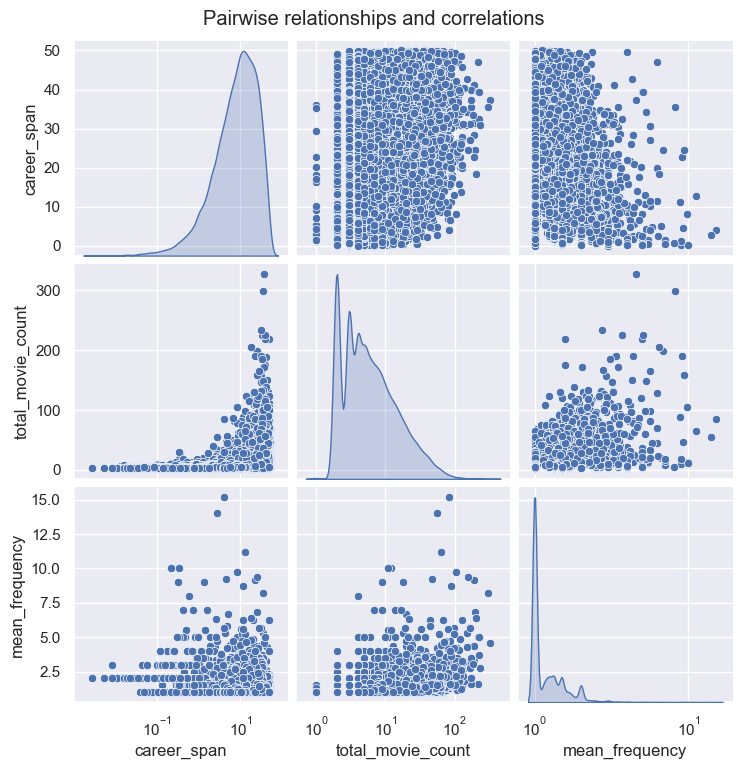

In [97]:
freq_span_nbmv = pd.merge(mean_frequency, actor_career_span, on=['actor_name', 'gender', 'region'])
freq_span_nbmv = pd.merge(freq_span_nbmv, actor_nb_movie, on=['actor_name', 'gender', 'region'])
freq_span_nbmv.dropna(subset=['career_span', 'total_movie_count', 'mean_frequency'], inplace=True)

data_pairplot = freq_span_nbmv[['career_span', 'total_movie_count', 'mean_frequency']]

sns.pairplot(data_pairplot, diag_kind='kde', diag_kws={'log_scale': 10})
plt.suptitle('Pairwise relationships and correlations', y=1.02)
plt.show()

### 4.2) Final score for longevity

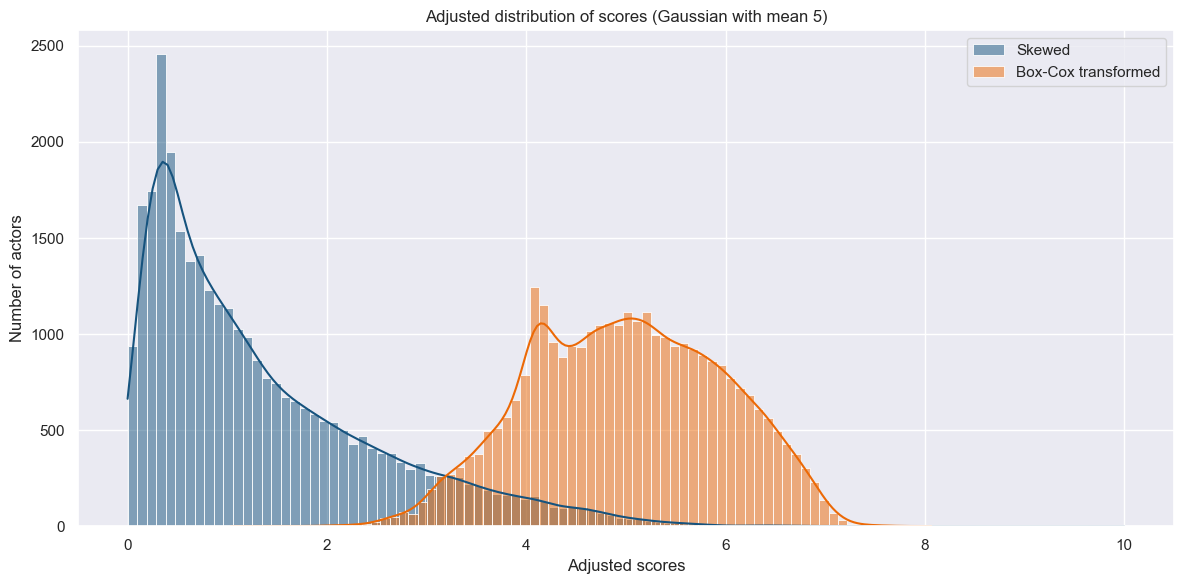

count    31624.000000
mean         5.000000
std          0.965573
min          1.036514
25%          4.251620
50%          4.999583
75%          5.736247
max          8.064661
Name: weighted_score, dtype: float64

In [103]:
normalized_data = (freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']] - freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']].min()) / (freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']].max() - freq_span_nbmv[['mean_frequency', 'career_span', 'total_movie_count']].min())

weights = {'mean_frequency': 0.33333, 'career_span': 0.33333, 'total_movie_count': 0.3333}
weighted_score = (normalized_data['mean_frequency'] * weights['mean_frequency']) + (normalized_data['career_span'] * weights['career_span']) + (normalized_data['total_movie_count'] * weights['total_movie_count'])

rescaled_score = (weighted_score - weighted_score.min()) / (weighted_score.max() - weighted_score.min()) * 10
freq_span_nbmv['weighted_score'] = rescaled_score
freq_span_nbmv['weighted_score'] += 0.00001

# Box-Cox transformation
transformed_scores, lambda_value = stats.boxcox(shifted_scores)
mean_of_transformed_scores = np.mean(transformed_scores)

factor = 5 - mean_of_transformed_scores
adjusted_scores = transformed_scores + factor

plt.figure(figsize=(12, 6))

sns.histplot(rescaled_score, kde=True, color = '#16537e', label = 'Skewed')
plt.xlabel('Initial weighted Scores')
plt.ylabel('Number of actors')
plt.title('Skewed distribution of scores')

sns.histplot(adjusted_scores, kde=True, color = '#ec6906', label = 'Box-Cox transformed')
plt.xlabel('Adjusted scores')
plt.ylabel('Number of actors')
plt.title('Adjusted distribution of scores (Gaussian with mean 5)')

plt.legend()
plt.tight_layout()
plt.show()

freq_span_nbmv['weighted_score'] = adjusted_scores
freq_span_nbmv['weighted_score'].describe()

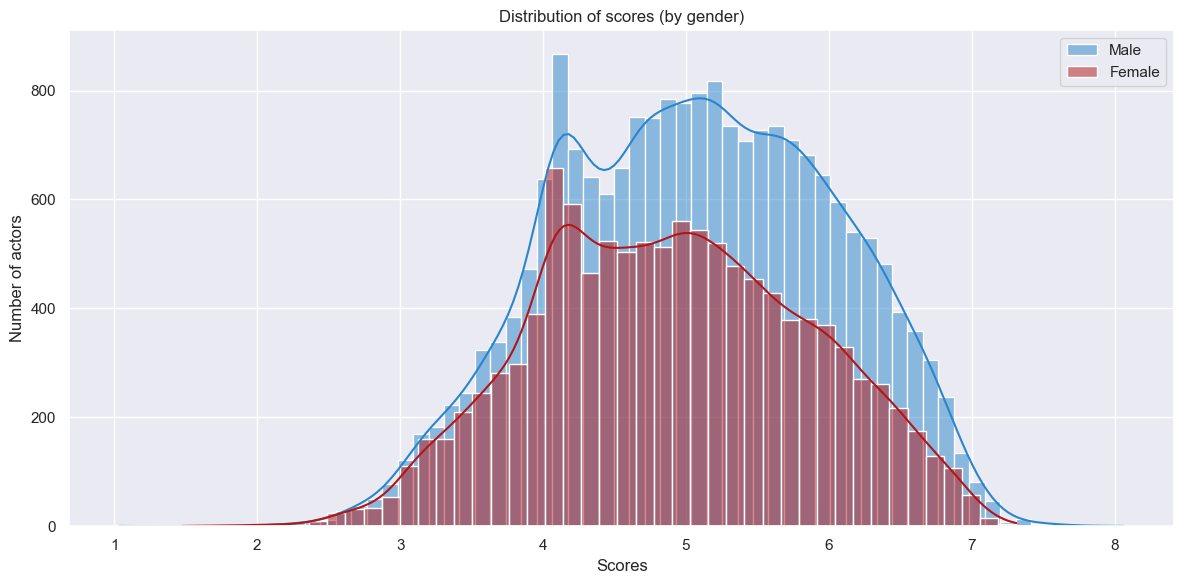

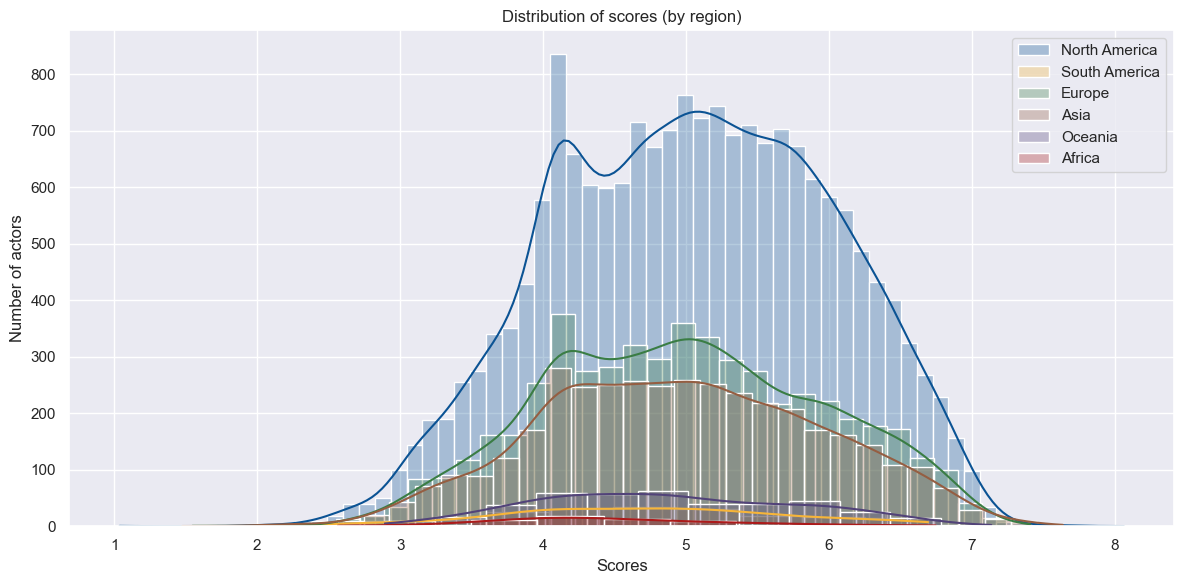

In [94]:
male_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['gender'] == 'M']
female_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['gender'] == 'F']

NA_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'North America']
SA_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'South America']
EU_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Europe']
AS_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Asia']
OC_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Oceania']
AF_freq_span_nbmv = freq_span_nbmv[freq_span_nbmv['region'] == 'Africa']

plt.figure(figsize=(12, 6))

sns.histplot(male_freq_span_nbmv['weighted_score'], kde=True, label='Male',color='#2986cc')
sns.histplot(female_freq_span_nbmv['weighted_score'], kde=True, label='Female',color='#b41515')
plt.xlabel('Scores')
plt.ylabel('Number of actors')
plt.title('Distribution of scores (by gender)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

sns.histplot(NA_freq_span_nbmv['weighted_score'], kde=True, label='North America',color='#0b5394', alpha = 0.3)
sns.histplot(SA_freq_span_nbmv['weighted_score'], kde=True, label='South America',color='#f7b538', alpha = 0.3)
sns.histplot(EU_freq_span_nbmv['weighted_score'], kde=True, label='Europe',color='#3a7d44', alpha = 0.3)
sns.histplot(AS_freq_span_nbmv['weighted_score'], kde=True, label='Asia',color='#955e42', alpha = 0.3)
sns.histplot(OC_freq_span_nbmv['weighted_score'], kde=True, label='Oceania',color='#524379', alpha = 0.3)
sns.histplot(AF_freq_span_nbmv['weighted_score'], kde=True, label='Africa',color='#ac1a1a', alpha = 0.3)

plt.xlabel('Scores')
plt.ylabel('Number of actors')
plt.title('Distribution of scores (by region)')
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
top_actors = freq_span_nbmv.sort_values(by='weighted_score', ascending=False)
top_actors.head(30)

,actor_name,mean_frequency,gender,region,min,max,career_span,actor_age_at_movie_release,mid_career_age,total_movie_count,weighted_score
22485,Oliver Hardy,8.187500,M,North America,1914-04-21,1949-09-15,35.427397,NaN,NaN,299,8.064661
21217,Mithun Chakraborty,4.567568,M,Other,1976-01-01,2013-05-15,37.394521,44.0,62.697260,328,7.959547
21249,Moe Howard,5.030303,M,North America,1930-09-28,1970-02-05,39.383562,NaN,NaN,225,7.743421
17141,Larry Fine,5.000000,M,North America,1930-09-28,1970-02-05,39.383562,55.0,74.691781,219,7.724147
7017,Dharmendra Deol,1.586207,M,Asia,1964-10-08,2011-10-27,47.082192,75.0,98.541096,218,7.637847
10959,Harold Lloyd,9.150000,M,North America,1913-05-08,1936-02-07,22.767123,NaN,NaN,191,7.601846
1138,Amitabh Bachchan,3.297297,M,Asia,1972-02-23,2013-05-10,41.238356,NaN,NaN,189,7.552389
25781,Roscoe Arbuckle,9.375000,M,North America,1909-07-01,1933-12-30,24.515068,NaN,NaN,158,7.551059
9316,Frank Welker,4.323529,M,North America,1969-12-31,2012-10-09,42.802740,30.0,51.401370,150,7.536224
18820,Mammootty,3.714286,M,Other,1980-05-16,2012-10-19,32.449315,43.0,59.224658,225,7.514790
